In [1]:
#importing the required libraries.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from pylab import plot,show
from pylab import legend, title, xlabel, ylabel
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [3]:
spark = SparkSession.Builder().appName('Project').getOrCreate()
sqlCtx = SQLContext(spark)

In [4]:
# Importing the data :
aisles = spark.read.csv("Input/aisles.csv", header='true', inferSchema='true')
departments = spark.read.csv("Input/departments.csv", header='true', inferSchema='true')
orders = spark.read.csv("Input/orders.csv", header='true', inferSchema='true')
products = spark.read.csv("Input/products.csv", header='true', inferSchema='true')
order_products_prior= spark.read.csv("Input/order_products__prior.csv", header='true', inferSchema='true')

In [5]:
aisles.show(5)

+--------+--------------------+
|aisle_id|               aisle|
+--------+--------------------+
|       1|prepared soups sa...|
|       2|   specialty cheeses|
|       3| energy granola bars|
|       4|       instant foods|
|       5|marinades meat pr...|
+--------+--------------------+
only showing top 5 rows



In [6]:
departments.show(5)

+-------------+----------+
|department_id|department|
+-------------+----------+
|            1|    frozen|
|            2|     other|
|            3|    bakery|
|            4|   produce|
|            5|   alcohol|
+-------------+----------+
only showing top 5 rows



In [7]:
orders.show(5)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows



In [8]:
products.show(5)

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing top 5 rows



In [9]:
order_products_prior.show(5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
+--------+----------+-----------------+---------+
only showing top 5 rows



In [10]:
# Combining Dataset :
df = order_products_prior.join(orders, on="order_id",how="left")
df = df.join(products,on="product_id",how="left")
df = df.join(departments,on="department_id",how="left")
df = df.join(aisles,on="aisle_id",how="left")

In [11]:
df.show(5)

+--------+-------------+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+--------------------+----------+-----------------+
|aisle_id|department_id|product_id|order_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|        product_name|department|            aisle|
+--------+-------------+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+--------------------+----------+-----------------+
|      91|           16|     47546| 3163494|                1|        1| 162382|   prior|          19|        1|               12|                   3.0|Chocolate Coconut...|dairy eggs|  soy lactosefree|
|      96|           20|     19019| 3163494|                2|        1| 162382|   prior|          19|        1|               12|                   3.0|Uncured Slow Cook...|      deli

## Exploratory Data Analysis for Instacart Market Basket

### 1. Most Frequently Bought Products

In [12]:
# Most sold Product
Frequently_Bought = df.groupBy("product_name"
                           ).agg({"product_id": "count"}
                                ).withColumnRenamed("count(product_id)", "Frq_sold"
                                                    ).orderBy(col("Frq_sold").desc())

Frequently_Bought.show(10)

+--------------------+--------+
|        product_name|Frq_sold|
+--------------------+--------+
|              Banana|  472565|
|Bag of Organic Ba...|  379450|
|Organic Strawberries|  264683|
|Organic Baby Spinach|  241921|
|Organic Hass Avocado|  213584|
|     Organic Avocado|  176815|
|         Large Lemon|  152657|
|        Strawberries|  142951|
|               Limes|  140627|
|  Organic Whole Milk|  137905|
+--------------------+--------+
only showing top 10 rows



In [13]:
output_path = f"EDA/Frequently_Bought"
Frequently_Bought = Frequently_Bought.coalesce(1)
Frequently_Bought.write.csv(output_path, header=True, mode="overwrite")
Frequently_Bought = Frequently_Bought.toPandas()

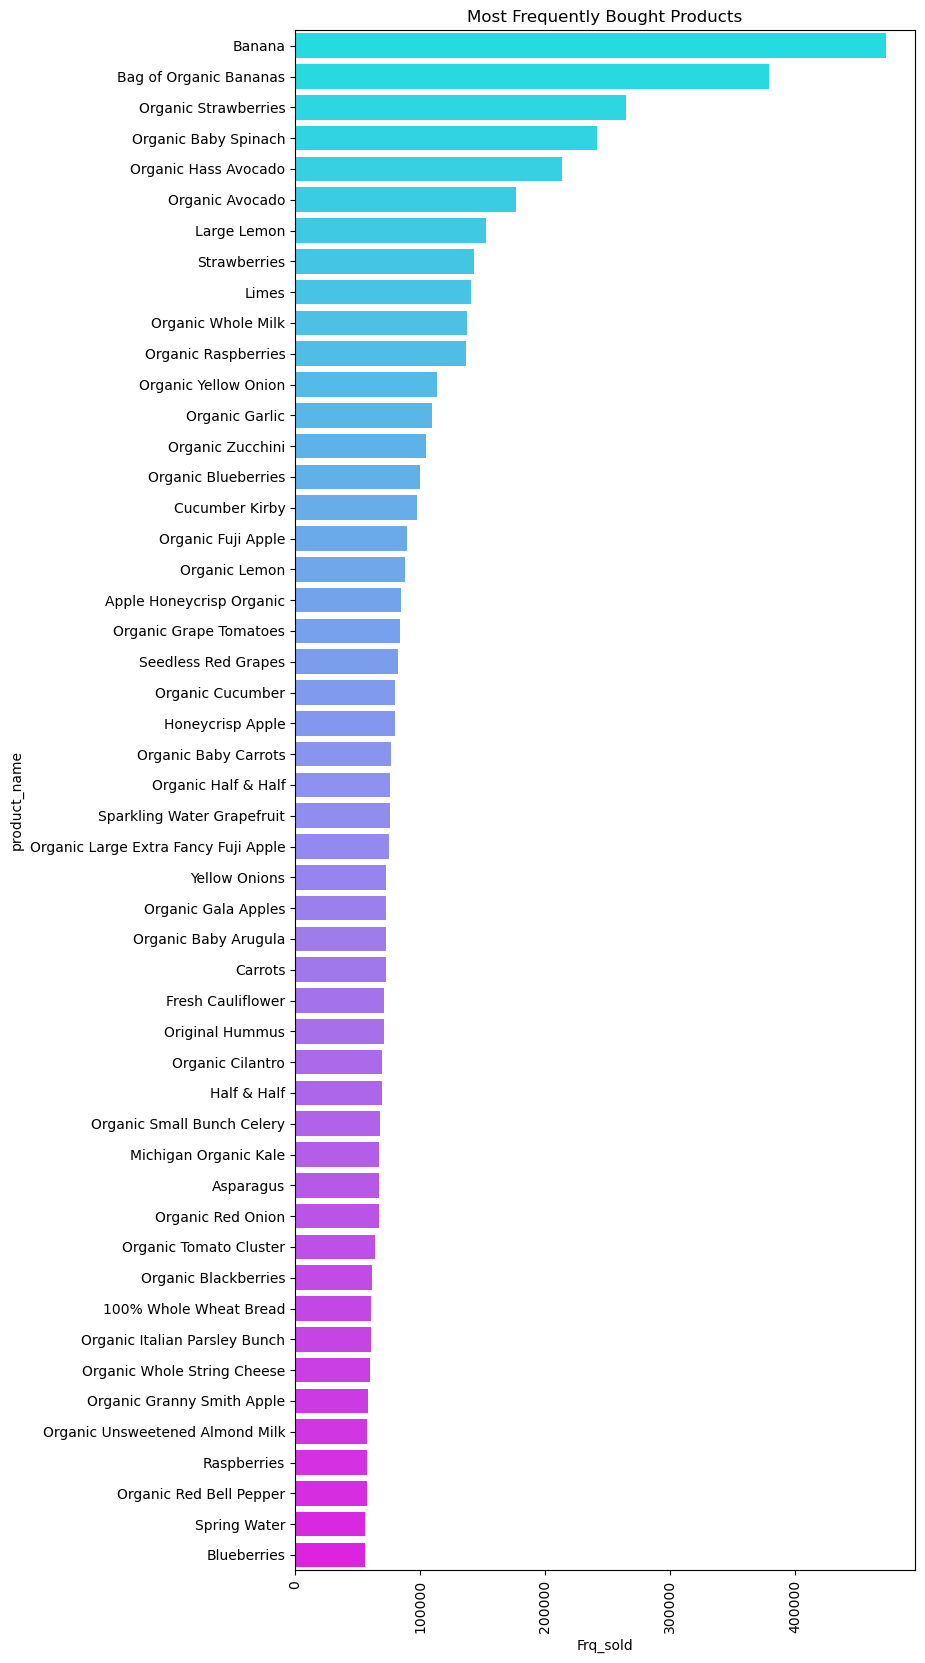

In [14]:
Frequently_Bought = Frequently_Bought[:50]
plt.figure(figsize=(8,20))
sns.barplot(data = Frequently_Bought, y = "product_name", x = "Frq_sold", palette='cool')
plt.xticks(rotation=90)
title("Most Frequently Bought Products")
plt.savefig("EDA/Images/Frequently_Bought.png")
plt.show()

### 2. Products Sold by Department

In [15]:
# Most sold Product by Department
Frequently_Bought_Dept = df.groupBy("department"
                           ).agg({"product_id": "count"}
                                ).withColumnRenamed("count(product_id)", "Frq_sold"
                                                    ).orderBy(col("Frq_sold").desc())

Frequently_Bought_Dept.show(10)

+---------------+--------+
|     department|Frq_sold|
+---------------+--------+
|        produce| 9479291|
|     dairy eggs| 5414016|
|         snacks| 2887550|
|      beverages| 2690129|
|         frozen| 2236432|
|         pantry| 1875577|
|         bakery| 1176787|
|   canned goods| 1068058|
|           deli| 1051249|
|dry goods pasta|  866627|
+---------------+--------+
only showing top 10 rows



In [16]:
output_path = f"EDA/Frequently_Bought_Dept"
Frequently_Bought_Dept = Frequently_Bought_Dept.coalesce(1)
Frequently_Bought_Dept.write.csv(output_path, header=True, mode="overwrite")
Frequently_Bought_Dept = Frequently_Bought_Dept.toPandas()

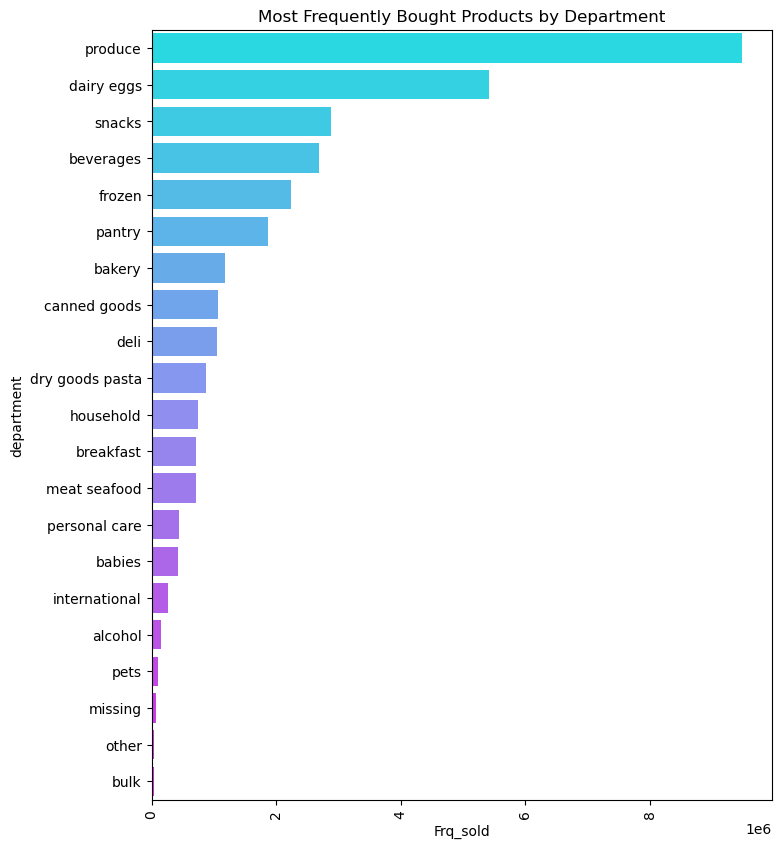

In [17]:
plt.figure(figsize=(8,10))
sns.barplot(data = Frequently_Bought_Dept, y = "department", x = "Frq_sold", palette='cool')
plt.xticks(rotation=90)
title("Most Frequently Bought Products by Department")
plt.savefig("EDA/Images/Frequently_Bought_Dept.png")
plt.show()

### 3. Aisles with the Highest Sales

In [18]:
# Most sold Product by Aisles
Frequently_Bought_Aisles = df.groupBy("aisle"
                           ).agg({"product_id": "count"}
                                ).withColumnRenamed("count(product_id)", "Frq_sold"
                                                    ).orderBy(col("Frq_sold").desc())

Frequently_Bought_Aisles.show(10)

+--------------------+--------+
|               aisle|Frq_sold|
+--------------------+--------+
|        fresh fruits| 3642188|
|    fresh vegetables| 3418021|
|packaged vegetabl...| 1765313|
|              yogurt| 1452343|
|     packaged cheese|  979763|
|                milk|  891015|
|water seltzer spa...|  841533|
|      chips pretzels|  722470|
|     soy lactosefree|  638253|
|               bread|  584834|
+--------------------+--------+
only showing top 10 rows



In [19]:
output_path = f"EDA/Frequently_Bought_Aisles"
Frequently_Bought_Aisles = Frequently_Bought_Aisles.coalesce(1)
Frequently_Bought_Aisles.write.csv(output_path, header=True, mode="overwrite")
Frequently_Bought_Aisles = Frequently_Bought_Aisles.toPandas()

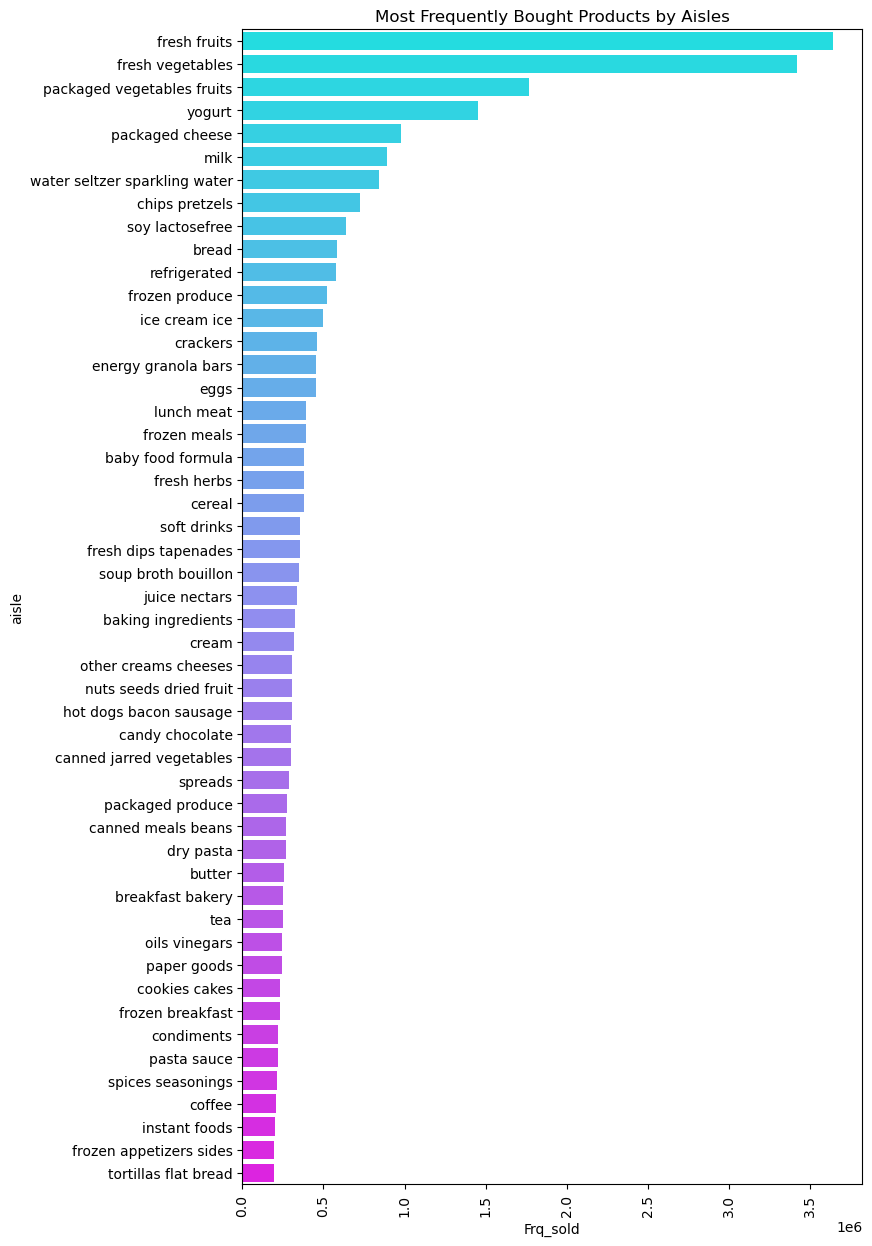

In [20]:
Frequently_Bought_Aisles = Frequently_Bought_Aisles[:50]
plt.figure(figsize=(8,15))
sns.barplot(data = Frequently_Bought_Aisles, y = "aisle", x = "Frq_sold", palette='cool')
plt.xticks(rotation=90)
title("Most Frequently Bought Products by Aisles")
plt.savefig("EDA/Images/Frequently_Bought_Aisles.png")
plt.show()

### 3. Weekly Sales Trend

#### Most sold Product by Days

In [21]:
# Most sold Product by Days
Frequently_Bought_Days = df.groupBy("order_dow"
                           ).agg({"product_id": "count"}
                                ).withColumnRenamed("count(product_id)", "Frq_sold"
                                                    ).orderBy(col("Frq_sold").desc())

Frequently_Bought_Days.show(10)

+---------+--------+
|order_dow|Frq_sold|
+---------+--------+
|        0| 6209666|
|        1| 5665856|
|        6| 4500304|
|        2| 4217798|
|        5| 4209533|
|        3| 3844117|
|        4| 3787215|
+---------+--------+



In [22]:
output_path = f"EDA/Frequently_Bought_Days"
Frequently_Bought_Days = Frequently_Bought_Days.coalesce(1)
Frequently_Bought_Days.write.csv(output_path, header=True, mode="overwrite")
Frequently_Bought_Days = Frequently_Bought_Days.toPandas()         

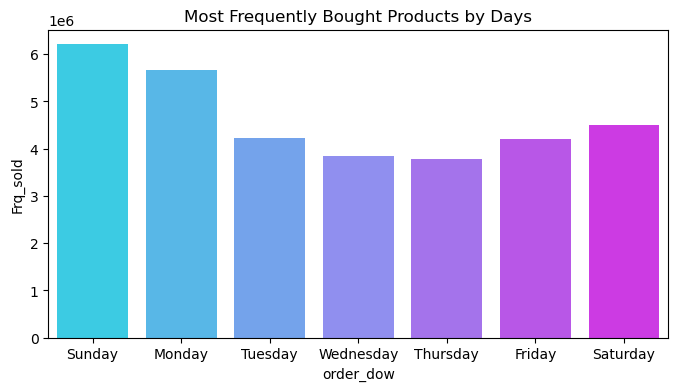

In [23]:
l1 = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize=(8,4))
sns.barplot(data = Frequently_Bought_Days, x = "order_dow", y = "Frq_sold", palette='cool'
           ).set_xticklabels(l1)
title("Most Frequently Bought Products by Days")
plt.savefig("EDA/Images/Frequently_Bought_Days.png")
plt.show()

#### Orders by Days

In [24]:
# Order by Days
Order_Count_Days = df.groupBy("order_dow").agg(countDistinct("order_id"
                                                            ).alias("Distinct_order_count")
                                              ).orderBy(col("Distinct_order_count").desc())


Order_Count_Days.show(10)

+---------+--------------------+
|order_dow|Distinct_order_count|
+---------+--------------------+
|        0|              557772|
|        1|              556705|
|        2|              441955|
|        5|              425982|
|        6|              418848|
|        3|              412400|
|        4|              401212|
+---------+--------------------+



In [25]:
output_path = f"EDA/Order_Count_Days"
Order_Count_Days = Order_Count_Days.coalesce(1)
Order_Count_Days.write.csv(output_path, header=True, mode="overwrite")
Order_Count_Days = Order_Count_Days.toPandas()  

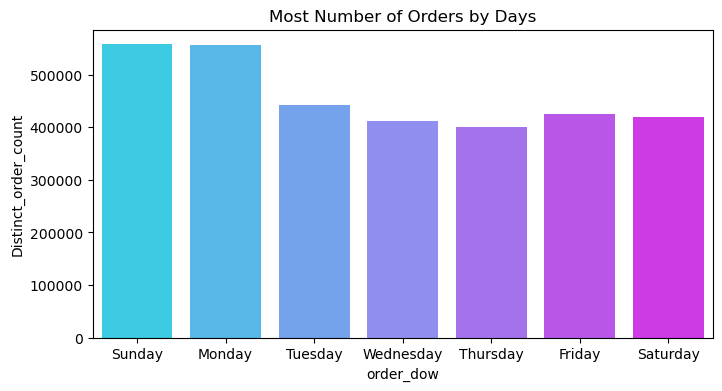

In [26]:
plt.figure(figsize=(8,4))
sns.barplot(data = Order_Count_Days, x = "order_dow", y = "Distinct_order_count", palette='cool'
           ).set_xticklabels(l1)
title("Most Number of Orders by Days")
plt.savefig("EDA/Images/Order_Count_Days.png")
plt.show()

### 5. Daily Sales Trend Hourly

In [27]:
# Number of Order by Hours
Order_Count_Hours = df.groupBy("order_hour_of_day").agg(countDistinct("order_id"
                                                            ).alias("Distinct_order_count")
                                              ).orderBy(col("Distinct_order_count").desc())


Order_Count_Hours.show(10)

+-----------------+--------------------+
|order_hour_of_day|Distinct_order_count|
+-----------------+--------------------+
|               10|              271885|
|               11|              268006|
|               15|              266132|
|               14|              265556|
|               13|              261174|
|               12|              256206|
|               16|              255949|
|                9|              243496|
|               17|              214080|
|               18|              170998|
+-----------------+--------------------+
only showing top 10 rows



In [28]:
output_path = f"EDA/Order_Count_Hours"
Order_Count_Hours = Order_Count_Hours.coalesce(1)
Order_Count_Hours.write.csv(output_path, header=True, mode="overwrite")
Order_Count_Hours = Order_Count_Hours.toPandas()  

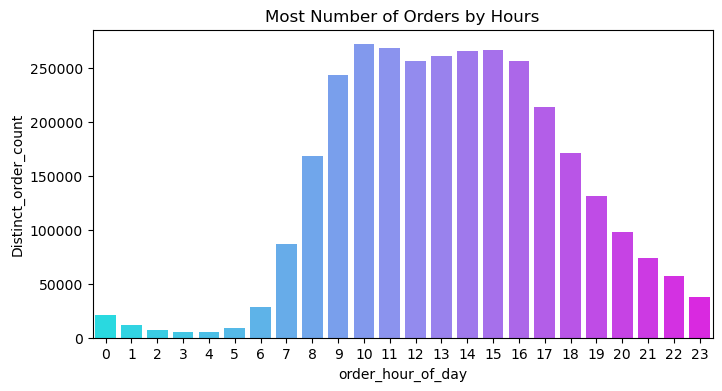

In [29]:
plt.figure(figsize=(8,4))
sns.barplot(data = Order_Count_Hours, x = "order_hour_of_day", 
            y = "Distinct_order_count", palette='cool')
title("Most Number of Orders by Hours")
plt.savefig("EDA/Images/Order_Count_Hours.png")
plt.show()

### 6. Days Since Prior Order

In [30]:
# Days since prior Orders
Days_Count_Prior = df.groupBy("days_since_prior_order").agg(countDistinct("order_id"
                                                            ).alias("Distinct_order_count")
                                              ).orderBy(col("Distinct_order_count").desc())


Days_Count_Prior.show(10)

+----------------------+--------------------+
|days_since_prior_order|Distinct_order_count|
+----------------------+--------------------+
|                   7.0|              306181|
|                  30.0|              306137|
|                   6.0|              230245|
|                   4.0|              214488|
|                   3.0|              210665|
|                   5.0|              206691|
|                  null|              206209|
|                   2.0|              187723|
|                   8.0|              173259|
|                   1.0|              141011|
+----------------------+--------------------+
only showing top 10 rows



In [31]:
output_path = f"EDA/Days_Count_Prior"
Days_Count_Prior = Days_Count_Prior.coalesce(1)
Days_Count_Prior.write.csv(output_path, header=True, mode="overwrite")
Days_Count_Prior = Days_Count_Prior.toPandas()  

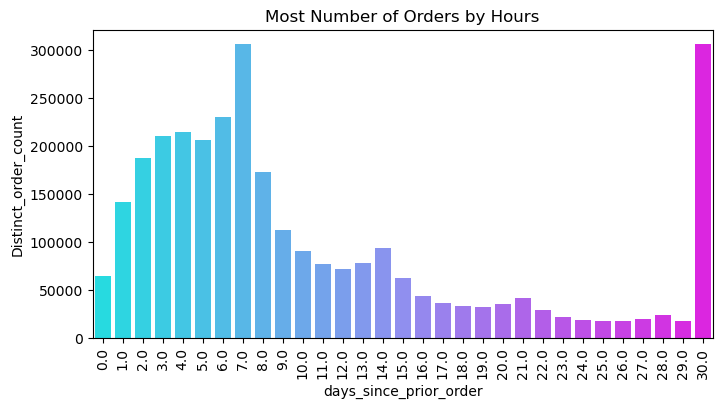

In [32]:
plt.figure(figsize=(8,4))
sns.barplot(data = Days_Count_Prior, x = "days_since_prior_order", 
            y = "Distinct_order_count", palette='cool')
plt.xticks(rotation=90)
title("Most Number of Orders by Hours")
plt.savefig("EDA/Images/Days_Count_Prior.png") 
plt.show()

### 7. Department-wise Re-Ordering Frequency

In [33]:
# Department-wise Re-Ordering Frequency
Freq_Dept_wise_Reorder = df.filter(col("reordered") == 1).groupBy(
            "department").agg(countDistinct("order_id"
                                           ).alias("Distinct_order_count"))


Freq_Dept_wise_Reorder.show(10)

# select department, count(distinct order_id) from df group by department where reordered = 1;

+---------------+--------------------+
|     department|Distinct_order_count|
+---------------+--------------------+
|      beverages|             1068642|
|   meat seafood|              346705|
|         frozen|              761976|
|           deli|              502229|
|dry goods pasta|              312040|
|           bulk|               19687|
|          other|               14565|
|         babies|              120116|
|         bakery|              589018|
|        produce|             1962871|
+---------------+--------------------+
only showing top 10 rows



In [34]:
output_path = f"EDA/Freq_Dept_wise_Reorder"
Freq_Dept_wise_Reorder = Freq_Dept_wise_Reorder.coalesce(1)
Freq_Dept_wise_Reorder.write.csv(output_path, header=True, mode="overwrite")
Freq_Dept_wise_Reorder = Freq_Dept_wise_Reorder.toPandas() 

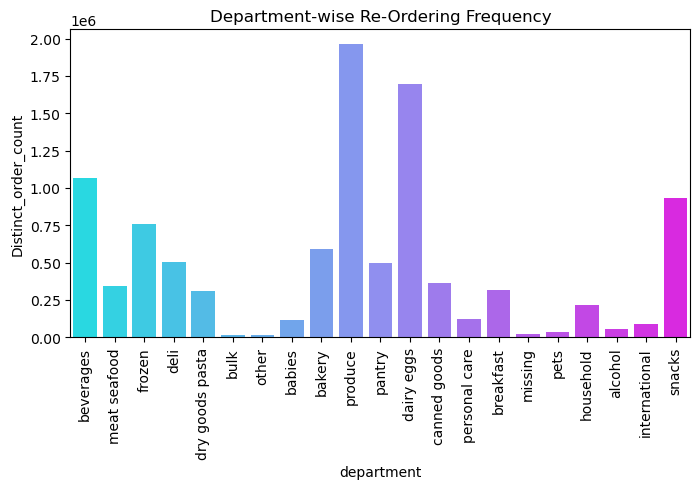

In [35]:
plt.figure(figsize=(8,4))
sns.barplot(data = Freq_Dept_wise_Reorder, x = "department", 
            y = "Distinct_order_count", palette='cool')
plt.xticks(rotation=90)
title("Department-wise Re-Ordering Frequency")
plt.savefig("EDA/Images/Freq_Dept_wise_Reorder.png") 
plt.show()

### 8. Top 10 Re-Ordered Products

In [36]:
# Top 10 Re-Ordered Products
Frequently_Bought_Reorder = df.filter(col("reordered") == 1
                                  ).groupBy("product_name"
                                            ).agg({"product_id": "count"}
                                                ).withColumnRenamed("count(product_id)", "Frq_sold"
                                                                    ).orderBy(col("Frq_sold").desc())

Frequently_Bought_Reorder.show(10)

+--------------------+--------+
|        product_name|Frq_sold|
+--------------------+--------+
|              Banana|  398609|
|Bag of Organic Ba...|  315913|
|Organic Strawberries|  205845|
|Organic Baby Spinach|  186884|
|Organic Hass Avocado|  170131|
|     Organic Avocado|  134044|
|  Organic Whole Milk|  114510|
|         Large Lemon|  106255|
| Organic Raspberries|  105409|
|        Strawberries|   99802|
+--------------------+--------+
only showing top 10 rows



In [37]:
output_path = f"EDA/Freq_Dept_wise_Reorder"
Frequently_Bought_Reorder = Frequently_Bought_Reorder.coalesce(1)
Frequently_Bought_Reorder.write.csv(output_path, header=True, mode="overwrite")
Frequently_Bought_Reorder = Frequently_Bought_Reorder.toPandas() 

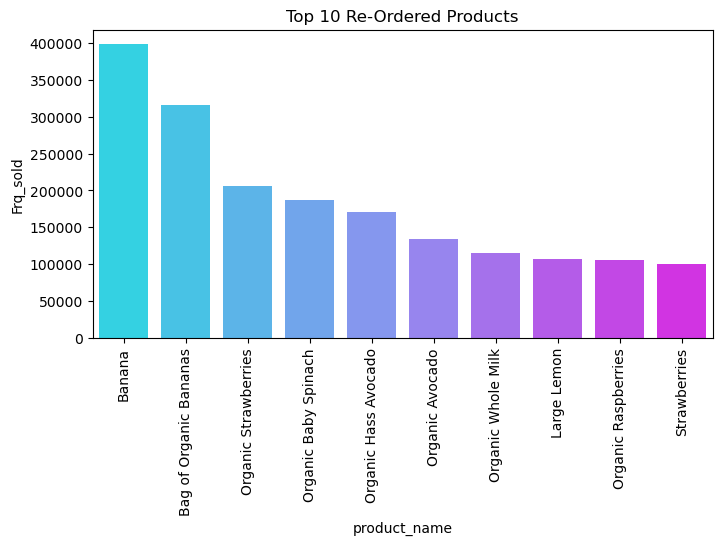

In [38]:
Frequently_Bought_Reorder = Frequently_Bought_Reorder[:10]
plt.figure(figsize=(8,4))
sns.barplot(data = Frequently_Bought_Reorder, x = "product_name", 
            y = "Frq_sold", palette='cool')
plt.xticks(rotation=60)
title("Top 10 Re-Ordered Products")
plt.savefig("EDA/Images/Frequently_Bought_Reorder.png") 
plt.show()

### 9. Customer Segmentation

In [39]:
# Customer Segmentation
Customer_Segmentation = df.groupBy("user_id"
                                    ).agg(countDistinct("order_id"
                                           ).alias("Order_count")
                                        )

Customer_Segmentation = Customer_Segmentation.withColumn("customer_category",
                                  when(col("Order_count") > 60, "High Frequency Customer")
                                  .when((col("Order_count") >= 30) & (col("Order_count") <= 60),
                                        "Medium Frequency Customer")
                                  .when((col("Order_count") >= 10) & (col("Order_count") < 30),
                                        "Low Frequency Customer")
                                  .when(col("Order_count") < 10, "Occasional Customer")
                                  .otherwise("Unknown"))

Customer_Segmentation = Customer_Segmentation.groupBy("customer_category"
                                    ).agg(countDistinct("user_id"
                                           ).alias("User_count")
                                        )

Customer_Segmentation.show(10)



+--------------------+----------+
|   customer_category|User_count|
+--------------------+----------+
| Occasional Customer|    104513|
|Low Frequency Cus...|     72513|
|Medium Frequency ...|     22918|
|High Frequency Cu...|      6265|
+--------------------+----------+



In [40]:
output_path = f"EDA/Customer_Segmentation"
Customer_Segmentation = Customer_Segmentation.coalesce(1)
Customer_Segmentation.write.csv(output_path, header=True, mode="overwrite")
Customer_Segmentation = Customer_Segmentation.toPandas() 

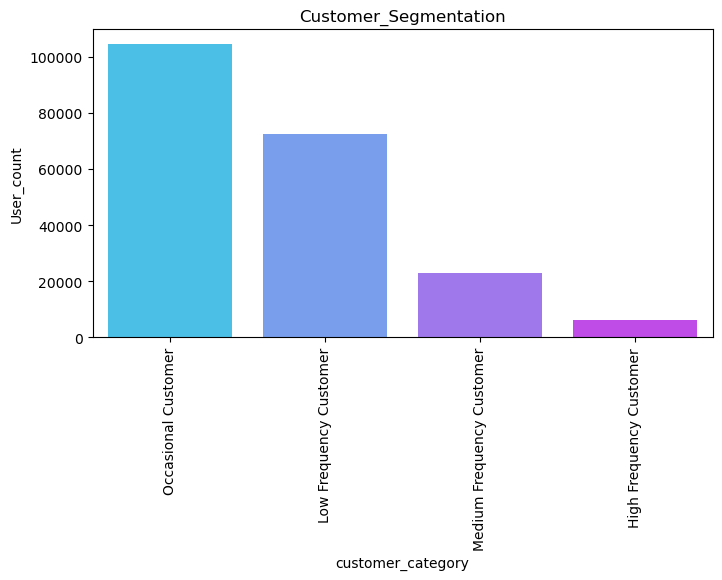

In [41]:
plt.figure(figsize=(8,4))
sns.barplot(data = Customer_Segmentation, x = "customer_category", 
            y = "User_count", palette='cool')
plt.xticks(rotation=45)
title("Customer_Segmentation")
plt.savefig("EDA/Images/Customer_Segmentation.png") 
plt.show()